In [1]:
import maboss
import ginsim
import pandas as pd 
import numpy as np


from identification_patients.get_patients_sens_res import get_patients

from create_generic_models.create_generic_patients_cfgs import create_generic_patients_cfgs_bnds
from pre_process_data.pre_process_genes import create_table_rna_seq_patients, process_genes

from create_person_models.tailor_cfgs_patients_gene import personalized_patients_genes_cfgs
from create_person_models.tailor_bnd_mutations import personalized_patients_mutations_bnds
from create_person_models.tailor_bnd_tsg_onco_mutations import tailor_bnd_tsg_onco_mut


from MaBoSS_simulation.MaBoSS_phenotype_distribution import compute_phenotypes_distribution, compute_mean_patients
from pre_process_data.identify_mutations_patients import identif_mutations_kras_egfr

# # from pre_process_profiles_table_data_lung import create_genes_patients

from stats.stats_proba import compute_mannwhitneyu_test_means
from results_MaBoSS_visualization.boxplot_phenotype import create_boxplot
from results_MaBoSS_visualization.create_phenotypes_patients_table import vizualise_table_phenotype_condition
from results_MaBoSS_visualization.patients_ids_phenotype_table import create_table_patients_phenotypes
from gene_enrichment.genes_signature import compute_genes_mean_signature
from pre_process_data.preprocess_mutations import preprocess_mutations_ds
from pre_process_data.pre_process_cnv import preprocess_cnv




In [2]:
import os
print(os.getcwd())


/Users/romane/repos/icr/Attractor-Resistance


Step 0: Import data 

In [3]:
# Import Data

annotations_models = pd.read_csv('data/model_list_20250407.csv')
mutations_data = pd.read_csv('data/mutations_all_20250318.csv')
drug_data = pd.read_csv('data/drug_sensitivity.csv')

montagud_data = (
    pd.read_csv('data/Montagud_inter_nodes_data.csv', header=1)
    .loc[:, ['Target node', 'Interaction type', 'Source']])
rna_seq_data = pd.read_csv('data/rnaseq_merged/rnaseq_merged_20250117.csv')
cnv_data = pd.read_csv('data/cellmodel_data/cnv_summary_20250207.csv')


models_depmap_annotation = pd.read_csv('data/cellmodel_data/model_list_20250423.csv')
mutations_data_depseq = pd.read_csv('data/depmap_data/OmicsSomaticMutations.csv')




/var/folders/83/pqwsm5cn7vscbq8l3fnf30qr0000gn/T/ipykernel_97918/4278837298.py:15: DtypeWarning: Columns (22,50,56,57,58,59,61) have mixed types. Specify dtype option on import or set low_memory=False.
  mutations_data_depseq = pd.read_csv('data/depmap_data/OmicsSomaticMutations.csv')


In [4]:
# chose folder where we want all the personalized boolean models and associated results saved 
drug_interest = 'Refametinib' #Pictilisib, 'Avagacestat' AZD8931 
tissue_interest = 'Lung'
tissue_remove = 'Haematopoietic and Lymphoid'

folder_pers_models=f'models/personalized_boolean_{drug_interest}_{tissue_interest}'
folder_result = f'results/{drug_interest}_{tissue_interest}'
folder_result_resistant = f'{folder_result}/resistant_results/only_gene_expression/single_input_on/phenotype_distribution_patients'
folder_result_sensitive = f'{folder_result}/sensitive_results/only_gene_expression/single_input_on/phenotype_distribution_patients'
folder_result_res_sen = f'{folder_result}/sensitive_resistant_results/genes_diff_expressed'


os.makedirs(folder_result_resistant, exist_ok=True)
os.makedirs(folder_result_sensitive, exist_ok=True)
os.makedirs(folder_result_res_sen, exist_ok=True)




# Output directories
output_dir_resistant = f'{folder_pers_models}/resistant_patient/generic_models'
output_dir_sec_resistant = f'{folder_pers_models}/resistant_patient/personalized_boolean_modified'
output_dir_sensitive = f'{folder_pers_models}/sensitive_patient/generic_models'
output_dir_sec_sensitive = f'{folder_pers_models}/sensitive_patient/personalized_boolean_modified'
bnd_dir_res = f'{folder_pers_models}/resistant_patient/personalized_boolean_modified/models_gene_expression'
bnd_dir_sens = f'{folder_pers_models}/sensitive_patient/personalized_boolean_modified/models_gene_expression'



Step 1: Pre-process data- Montagud nodes, rna-seq (filtered with patients IDs and Montagud nodes)

In [5]:
# Pre-process Montagud nodes

# Keep only the nodes of montagud not specific to Prostate 
montagud_nodes = list(set(montagud_data['Target node'].tolist() + montagud_data['Source'].tolist()))
montagud_nodes = [node for node in montagud_nodes if node != '0/1']
montagud_nodes = [node.upper() for node in montagud_nodes if isinstance(node, str)]
montagud_nodes.append('KRAS')
to_remove = ['RAS', 'FUSED_EVENT', 'NKX3_1', 'SPOP', 'AR_ERG']

montagud_nodes = [node for node in montagud_nodes if node not in to_remove]
montagud_nodes = list(set(montagud_nodes))

Step 1: Check what drug is the best to keep (the one with most resistant and sensitive)

In [6]:
# results = {}
# drug_interests = drug_data['DRUG_NAME'].unique().tolist()

# for drug in drug_interests:
#     top_resistant_ids, top_sensitive_ids, drug_data_filtered = get_patients(500, drug_data, annotations_models, drug, tissue_remove)
#     patients_ids = top_resistant_ids + top_sensitive_ids

#     drug_tissue_filtered = drug_data_filtered[drug_data_filtered['SANGER_MODEL_ID'].isin(patients_ids)]    
#     results[drug] = {
#          "name": drug,
#          "<-1.5": float((drug_tissue_filtered['Z_SCORE'] < -1.5).sum()),
#          ">1.5": float((drug_tissue_filtered['Z_SCORE'] > 1.5).sum()),
#          "mean": float(drug_tissue_filtered['Z_SCORE'].mean()),
#          "std": float(drug_tissue_filtered['Z_SCORE'].std()),
#          "abs_zscore": float(drug_tissue_filtered['Z_SCORE'].abs().mean()),
#      }

# pd_results = pd.DataFrame(results.values())
# pd_results.to_csv(f'{folder_result}/drug_analysis.csv', index=False)




Step 2: Select cancer and drug of interest (tissue_interest, drug_interest)
Get the 100 most sensitive patient
Pre-process data


In [6]:
# Get patients IDs

# changed the drug name to Pictilisib !!!!

# top_resistant_ids, top_sensitive_ids= get_patients(drug_data, annotations_models, drug_interest, tissue_interest)
top_resistant_ids, top_sensitive_ids, drug_tissue_data= get_patients(20, drug_data, annotations_models, drug_interest, tissue_interest, tissue_remove)
patients_ids = top_sensitive_ids + top_resistant_ids

/Users/romane/repos/icr/Attractor-Resistance/identification_patients/get_patients_sens_res.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annotations_models['tissue'] = annotations_models['tissue'].str.upper()
/Users/romane/repos/icr/Attractor-Resistance/identification_patients/get_patients_sens_res.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annotations_models_filtered.rename(columns={"model_id": "SANGER_MODEL_ID"}, inplace=True)


In [ ]:
# Pre-process RNA seq data (keep only montagud_nodes and patients ids) and create table for high and low expression
rna_seq_data_filtered = process_genes(patients_ids, montagud_nodes, rna_seq_data)
table_rna_seq_patients = create_table_rna_seq_patients(rna_seq_data_filtered)

# check how many genes info we have the selected patients
# print(rna_seq_data.head())
# rna_seq_data = rna_seq_data[rna_seq_data['model_id'].isin(patients_ids)]
# rna_seq_data = rna_seq_data[rna_seq_data['gene_symbol'].isin(montagud_nodes)]
# print(rna_seq_data)
# print(len(rna_seq_data['model_id'].unique().tolist()))

In [ ]:
mutations_data_filtered_combined = preprocess_mutations_ds(patients_ids, models_depmap_annotation, mutations_data_depseq,montagud_nodes)
print(mutations_data_filtered_combined)

In [7]:
# preprocess cnv
cnv_data_filtered = preprocess_cnv(cnv_data, montagud_nodes,patients_ids)
print(cnv_data_filtered)

         model_id symbol  total_copy_number    cn_category
71308   SIDM00133  NCOR1               4.00           Gain
71428   SIDM00133  EP300               2.00           Loss
71487   SIDM00133   BCL2               2.00           Loss
71491   SIDM00133    BAX               2.00           Loss
71494   SIDM00133  AXIN1               2.00           Loss
...           ...    ...                ...            ...
804558  SIDM01120    ERG               3.00           Gain
804560  SIDM01120   EGFR               3.00           Gain
804566  SIDM01120   DAXX               3.00           Gain
804580  SIDM01120    ATR               3.00           Gain
813115  SIDM01131    MYC              95.84  Amplification

[552 rows x 4 columns]


Step 3: Create generic boolean networks with the sensitive and resistant ID names


In [10]:
folder_generic_models_cfg = 'models/generic_models/Adeno_lung_Cancer.cfg'
folder_generic_models_bnd = 'models/generic_models/Adeno_lung_Cancer.bnd'
create_generic_patients_cfgs_bnds(folder_generic_models_cfg, folder_generic_models_bnd, folder_pers_models, top_resistant_ids, top_sensitive_ids, drug_interest, tissue_interest)


All .cfg and .bnd files created for sensitive and resistant patients.


Step 4: Personalize the cfg files with genes/ proteins


In [ ]:
# only three modif for resistant
personalized_patients_genes_cfgs(rna_seq_data, montagud_data, output_dir_resistant, output_dir_sec_resistant, patients_ids, table_rna_seq_patients, drug_interest)
personalized_patients_genes_cfgs(rna_seq_data, montagud_data, output_dir_sensitive, output_dir_sec_sensitive, patients_ids, table_rna_seq_patients, drug_interest)

Step 5: Identification of which patients id have KRAS or EGFR mutation
personalize the bnd files with the mutations common to Lung (KRAS/ EGFR):

In [12]:
tailor_bnd_tsg_onco_mut(mutations_data_filtered_combined,bnd_dir_res, bnd_dir_sens, drug_interest)

# personalized_patients_mutations_bnds(mutations_data,patients_ids,bnd_dir_res, drug_interest)
# personalized_patients_mutations_bnds(mutations_data,patients_ids,bnd_dir_sens, drug_interest)

🔍 Processing patient SIDM00134, gene: NF1
NF1 node found. Replacing...
SIDM00134: mutations — nodes modified
No .bnd file found for patient: SIDM00711
🔍 Processing patient SIDM01131, gene: RB1
RB1 node found. Replacing...
SIDM01131: mutations — nodes modified
🔍 Processing patient SIDM00133, gene: NCOR1
NCOR1 node found. Replacing...
SIDM00133: mutations — nodes modified
🔍 Processing patient SIDM01120, gene: RB1
RB1 node found. Replacing...
🔍 Processing patient SIDM01120, gene: BRCA1
BRCA1 node found. Replacing...
SIDM01120: mutations — nodes modified
🔍 Processing patient SIDM00699, gene: RB1
RB1 node found. Replacing...
SIDM00699: mutations — nodes modified
🔍 Processing patient SIDM00296, gene: RB1
RB1 node found. Replacing...
SIDM00296: mutations — nodes modified
🔍 Processing patient SIDM00521, gene: RB1
RB1 node found. Replacing...
SIDM00521: mutations — nodes modified
🔍 Processing patient SIDM01044, gene: NF1
NF1 node found. Replacing...
SIDM01044: mutations — nodes modified
🔍 Proce

Step 6: compute the phenotype distribution 

In [13]:
dic_patient_resistant =f'{folder_pers_models}/resistant_patient/personalized_boolean_modified/models_gene_expression'
dic_patient_sensitive =f'{folder_pers_models}/sensitive_patient/personalized_boolean_modified/models_gene_expression'
inputs_list = ['EGF', 'FGF', 'TGFb', 'Nutrients', 'Hypoxia', 'Acidosis', 'Androgen', 'TNFalpha', 'Carcinogen']
patient_res_data_dict = compute_phenotypes_distribution(folder_result, dic_patient_resistant, inputs_list, 'resistant', drug_interest)
patient_sens_data_dict = compute_phenotypes_distribution(folder_result, dic_patient_sensitive, inputs_list, 'sensitive', drug_interest)
patients_res_df_mean, patients_res_df_std, stats_results_data_res_df = compute_mean_patients(patient_res_data_dict)
patients_sens_df_mean, patients_sens_df_std, stats_results_data_sens_df = compute_mean_patients(patient_sens_data_dict)
patients_res_df_mean.to_csv(f'{folder_result}/resistant_results/only_gene_expression/single_input_on/patients_resistant_df_mean_{drug_interest}.csv', index=True)
patients_res_df_std.to_csv(f'{folder_result}/resistant_results/only_gene_expression/single_input_on/patients_resistant_df_std_{drug_interest}.csv', index=True)
stats_results_data_res_df.to_csv(f'{folder_result}/resistant_results/only_gene_expression/single_input_on/patients_resistant_values_stats_{drug_interest}.csv', index=True)
stats_results_data_sens_df.to_csv(f'{folder_result}/sensitive_results/only_gene_expression/single_input_on/patients_sensitive_values_stats_{drug_interest}.csv', index=True)
patients_sens_df_mean.to_csv(f'{folder_result}/sensitive_results/only_gene_expression/single_input_on/patients_sensitive_df_mean_{drug_interest}.csv', index=True)
patients_sens_df_std.to_csv(f'{folder_result}/sensitive_results/only_gene_expression/single_input_on/patients_sensitive_df_std_{drug_interest}.csv', index=True)




--- Results for patient: SIDM00719_Refametinib ---
                  <nil>  Apoptosis  Proliferation  Metastasis
EGF_ON         0.498847   0.000000       0.173104    0.041208
FGF_ON         0.409989   0.212539       0.200894    0.014800
TGFb_ON        0.023400   0.740712       0.005000    0.004400
Nutrients_ON   0.350828   0.000000       0.538568    0.011217
Hypoxia_ON     0.767885   0.000000       0.140268    0.051866
Acidosis_ON    0.679046   0.000000       0.225979    0.026946
Androgen_ON    0.499447   0.000000       0.173504    0.040608
TNFalpha_ON    0.588243   0.002061       0.147767    0.188955
Carcinogen_ON  0.169133   0.547467       0.024200    0.000000

--- Results for patient: SIDM01120_Refametinib ---
                  <nil>  Apoptosis  Proliferation  Metastasis
EGF_ON         0.683057   0.306143       0.001400    0.001200
FGF_ON         0.417115   0.572698       0.003898    0.001200
TGFb_ON        0.063800   0.935800       0.000000    0.000400
Nutrients_ON   0.789339   0.

Step 7: Compute stats test between two mean datasets

In [14]:
patient_res_stats_values = pd.read_csv(f'{folder_result}/resistant_results/only_gene_expression/single_input_on/patients_resistant_values_stats_{drug_interest}.csv')
patient_sens_stats_values = pd.read_csv(f'{folder_result}/sensitive_results/only_gene_expression/single_input_on/patients_sensitive_values_stats_{drug_interest}.csv')
compute_mannwhitneyu_test_means(folder_result,patient_res_stats_values, patient_sens_stats_values, drug_interest)

Step 8: Vizualise the boxplot of phenotype distribution output

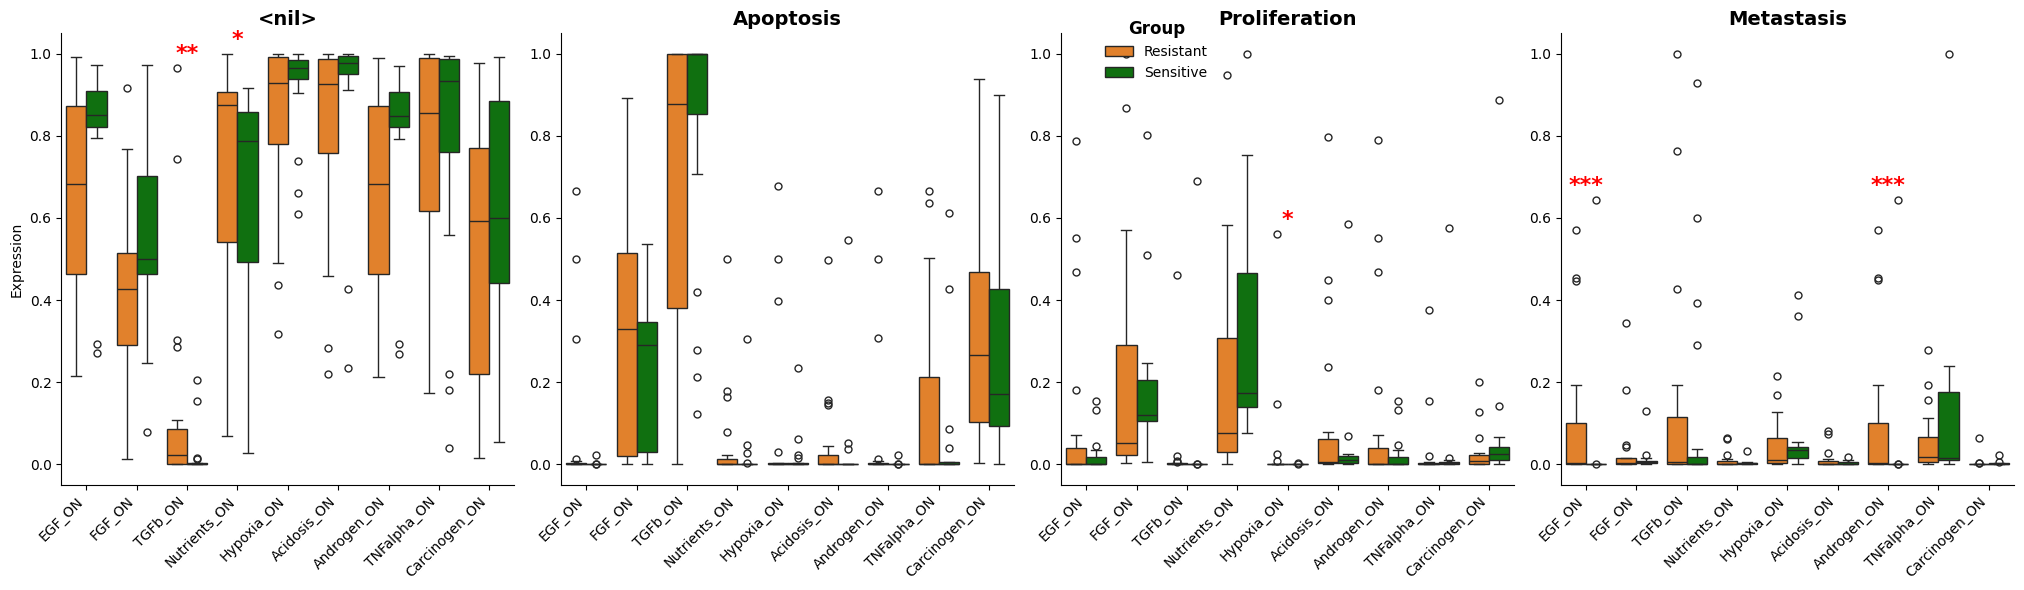

In [15]:
patient_res_values = pd.read_csv(f'{folder_result}/resistant_results/only_gene_expression/single_input_on/patients_resistant_values_stats_{drug_interest}.csv')
patient_sens_values = pd.read_csv(f'{folder_result}/sensitive_results/only_gene_expression/single_input_on/patients_sensitive_values_stats_{drug_interest}.csv')
data_greater_side = pd.read_csv(f'{folder_result}/sensitive_resistant_results/p_values_df_mannwhitneyu_greater_sign_{drug_interest}.csv')
create_boxplot(folder_result, patient_res_values, patient_sens_values, data_greater_side)

Step 9: create table of patients with conditions- phenotype

In [16]:
dir_res_data = f'{folder_result}/resistant_results/only_gene_expression/single_input_on/phenotype_distribution_patients'
dir_sens_data = f'{folder_result}/sensitive_results/only_gene_expression/single_input_on/phenotype_distribution_patients'
patients_phenot_table = create_table_patients_phenotypes(folder_result, dir_res_data, dir_sens_data)

Loaded data for SIDM00524_Refametinib_phenotypes, shape: (9, 4)
Loaded data for SIDM00767_Refametinib_phenotypes, shape: (9, 4)
Loaded data for SIDM00296_Refametinib_phenotypes, shape: (9, 4)
Loaded data for SIDM00990_Refametinib_phenotypes, shape: (9, 4)
Loaded data for SIDM00699_Refametinib_phenotypes, shape: (9, 4)
Loaded data for SIDM00770_Refametinib_phenotypes, shape: (9, 4)
Loaded data for SIDM01131_Refametinib_phenotypes, shape: (9, 4)
Loaded data for SIDM00719_Refametinib_phenotypes, shape: (9, 4)
Loaded data for SIDM01120_Refametinib_phenotypes, shape: (9, 4)
Loaded data for SIDM00506_Refametinib_phenotypes, shape: (9, 4)
Loaded data for SIDM00710_Refametinib_phenotypes, shape: (9, 4)
Loaded data for SIDM00508_Refametinib_phenotypes, shape: (9, 4)
Loaded data for SIDM00292_Refametinib_phenotypes, shape: (9, 4)
Loaded data for SIDM00183_Refametinib_phenotypes, shape: (9, 4)
Loaded data for SIDM00648_Refametinib_phenotypes, shape: (9, 4)
Loaded data for SIDM00521_Refametinib_ph

Step 10: Create heatmap figure 

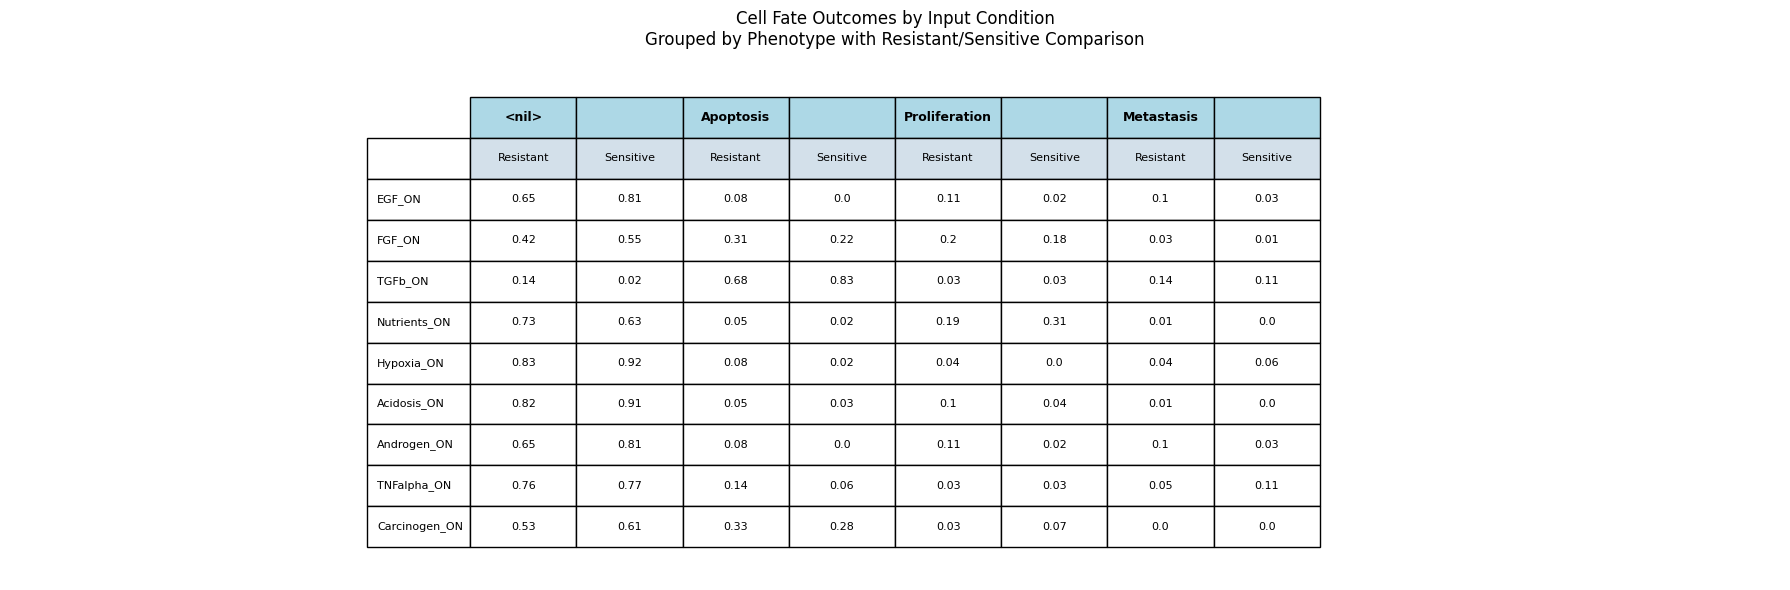

In [17]:
patient_resistant_mean = pd.read_csv(f'{folder_result}/resistant_results/only_gene_expression/single_input_on/patients_resistant_df_mean_{drug_interest}.csv')
patient_sensitive_mean = pd.read_csv(f'{folder_result}/sensitive_results/only_gene_expression/single_input_on/patients_sensitive_df_mean_{drug_interest}.csv')
vizualise_table_phenotype_condition(folder_result, patient_resistant_mean, patient_sensitive_mean)

Step 11: Identify genes differently expressed in the patients with high 

In [18]:
patients_phenot_table = pd.read_csv(f'{folder_result}/sensitive_resistant_results/patients_phenot_table.csv')
genes_stats_results_metast_TGFb,  len_resistant_group_id_metast_TGFb, len_sensitive_group_ids_metast_TGFb = compute_genes_mean_signature(rna_seq_data_filtered, folder_result, 'Metastasis', 'TGFb', patients_phenot_table, top_resistant_ids, top_sensitive_ids)
genes_stats_results_prolif_egf,  len_resistant_group_ids_prolif_egf, len_sensitive_group_ids_prolif_egf = compute_genes_mean_signature(rna_seq_data_filtered, folder_result, 'Proliferation', 'EGF', patients_phenot_table, top_resistant_ids, top_sensitive_ids)

/Users/romane/repos/icr/Attractor-Resistance/.env/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
/Users/romane/repos/icr/Attractor-Resistance/.env/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


In [19]:
print(len_resistant_group_id_metast_TGFb)
print(len_sensitive_group_ids_metast_TGFb)

print(len_resistant_group_ids_prolif_egf)
print(len_sensitive_group_ids_prolif_egf)

5
19
4
19


Step 11: check there is not correlation between phenotype distribution and cancer type 


In [20]:
# patients_phenot_table['SANGER_MODEL_ID'] = patients_phenot_table['Unnamed: 0'].str.split('_').str[0]
# conditions = [
#     patients_phenot_table['SANGER_MODEL_ID'].isin(top_resistant_ids),
#     patients_phenot_table['SANGER_MODEL_ID'].isin(top_sensitive_ids)
#     ]
# choices = ['Resistant', 'Sensitive']
# patients_phenot_table.loc[:,'Drug status'] = np.select(conditions, choices, default = '')



# ids_tissue_data = drug_tissue_data[['SANGER_MODEL_ID', 'tissue']]
# ids_tissue_data = ids_tissue_data.drop_duplicates(subset='SANGER_MODEL_ID')


# # merge tissues and model id 
# patients_phenot_table = pd.merge(patients_phenot_table, ids_tissue_data, on = 'SANGER_MODEL_ID')



# # look the number of each cancer for the condition-phenotype of interest
# condition = 'TGFb'
# phenotype = 'Metastasis'


# # resistant group changes according to what is the condition and the phenotype
# # group_proliferation_resistant: group with high phenotype 

# group_phenotype_resistant = patients_phenot_table[
#     (patients_phenot_table['Drug status'] == 'Resistant') & 
#     (patients_phenot_table[f'{condition}_ON_{phenotype}'] >= 0.1)
# ]

# # print(group_phenotype_resistant['tissue'].value_counts()) # EGF- proliferation: 4 lung, 1 breast, 1 haematopoetic
# #                                                           # TGFb- Metastasis: 21 haemato, 2 skin, 2 breast, 1 lung, 1 large intestine, 1 endom, 1 liver


In [21]:
# inputs = ['EGF', 'FGF', 'Nutrients', 'Androgen']
# results = []
# output_dir = f'{folder_result}/sensitive_results/only_gene_expression/all_inputs_on/phenotype_distribution_patients'
# os.makedirs(output_dir, exist_ok=True)
# cfg_files = [f for f in os.listdir(dic_patient_sensitive) if f.endswith(f"{drug_interest}.cfg")]
# for cfg_file in cfg_files:
#     cfg_path = os.path.join(dic_patient_sensitive, cfg_file)
#     base_name = os.path.splitext(cfg_file)[0]
#     bnd_path = os.path.join(dic_patient_sensitive, base_name + ".bnd")
#     model = maboss.load(bnd_path, cfg_path)
#     for input_node in inputs:
#         model.network.set_istate(input_node, [0.0, 1.0])  # ON
#     result = model.run()
#     probtraj = result.get_last_states_probtraj()
#     probtraj["Patient_ID"] = base_name
#     results.append(probtraj)
# combined_df = pd.concat(results, ignore_index=True)
# combined_csv_path = os.path.join(output_dir, "all_patients_all_inputs_on_probtraj.csv")
# combined_df.to_csv(combined_csv_path, index=False)
# print(f"Saved combined results to: {combined_csv_path}")


In [22]:
# results_resistant = pd.read_csv('results/resistant_results/only_gene_expression/all_inputs_on/phenotype_distribution_patients/all_patients_all_inputs_on_probtraj.csv')
# results_sensitive = pd.read_csv('results/sensitive_results/only_gene_expression/all_inputs_on/phenotype_distribution_patients/all_patients_all_inputs_on_probtraj.csv')



# print('Apoptosis')

# resistant_apopto_mean = results_resistant['Apoptosis'].mean()
# print(resistant_apopto_mean)

# sensitive_apopto_mean = results_sensitive['Apoptosis'].mean()
# print(sensitive_apopto_mean)



# print('Proliferation')
# resistant_prolif_mean = results_resistant['Proliferation'].mean()
# print(resistant_prolif_mean)

# sensitive_prolif_mean = results_sensitive['Proliferation'].mean()
# print(sensitive_prolif_mean)



# print('Metastasis')
# resistant_metas_mean = results_resistant['Metastasis'].mean()
# print(resistant_metas_mean)

# sensitive_metas_mean = results_sensitive['Metastasis'].mean()
# print(sensitive_metas_mean)


In [23]:
# TO DO: later- changes EGF and TGF initial states according to expression
